In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import os
import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.3


# Comparison Against A3C

In [2]:
# A3C 16-agent running reward

rewards16 = []
inFile =  open("./results/a3c-pong-16agent-running_rewards.txt",'r')

# Load the rewards
for row in inFile:
    rewards16.append(float(row.split(" ")[1][0:-1]))
#print(rewards16)

# Regenerate running rewards
running_reward16 = None
running_rewards16 = []
for item in rewards16:
    if running_reward16 == None:
        running_reward16 = item
    else:
        running_reward16 = running_reward16*.99+item*.01
    running_rewards16.append(running_reward16)

    #print(running_)
inFile.close()

# A3C 4-agent running reward

rewards4 = []
inFile =  open("./results/a3c-pong-4agent-running_rewards.txt",'r')
for row in inFile:
    rewards4.append(float(row.split(" ")[1][0:-1]))
running_reward4 = None
running_rewards4 = []
for item in rewards4:
    if running_reward4 == None:
        running_reward4 = item
    else:
        running_reward4 = running_reward4*.99+item*.01
    running_rewards4.append(running_reward4)
#print(running_)
inFile.close()

# A3C 1-agent running reward

rewards1 = []
inFile =  open("./results/a3c-pong-1agent-running_rewards.txt",'r')
for row in inFile:
    rewards1.append(float(row.split(" ")[1][0:-1]))
running_reward1 = None
running_rewards1 = []
for item in rewards1:
    if running_reward1 == None:
        running_reward1 = item
    else:
        running_reward1 = running_reward1*.99+item*.01
    running_rewards1.append(running_reward1)
inFile.close()

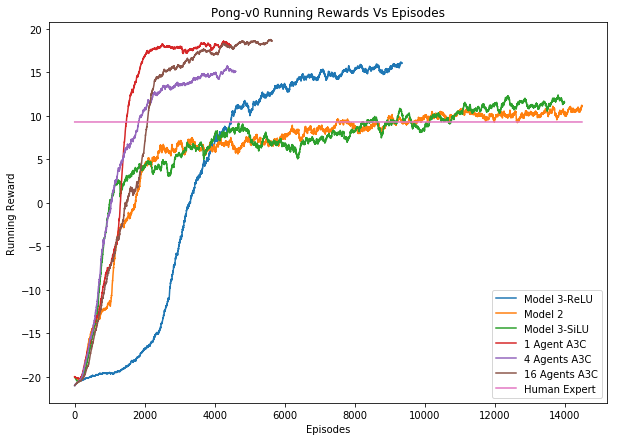

Max. Running Reward (1 Agent A3C): 18.61
Episode achieving max. Running Reward: 4257
Episode achieving Human Performance: 1477


Max. Running Reward (4 Agent A3C): 15.75
Episode achieving max. Running Reward: 4354
Episode achieving Human Performance: 1828


Max. Running Reward (16 Agent A3C): 18.77
Episode achieving max. Running Reward: 5602
Episode achieving Human Performance: 2078


Episode achieving max. Running Reward: 14497
Max. Running Reward (Model 2): 11.21
Episode achieving Human Performance: 7485


Max. Running Reward (Model 3-ReLU): 16.18
Episode achieving max. Running Reward: 9327
Episode achieving Human Performance: 4467


Episode achieving max. Running Reward: 13817
Max. Running Reward (Model 3-SiLU): 12.41
Episode achieving Human Performance: 8248


Human Performance: 9.300


In [3]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'

plt.figure(figsize=(10, 7))

data_file = './results/Pong-v0(AC-lstm-fullepisode-ep=9500).p'.format(game)
with open(data_file, 'rb') as f:
    data1 = pickle.load(f)

plt.plot(data1[:9350], label='Model 3-ReLU')

data_file = './results/Pong-v0-AC-noLSTM.p'.format(game)
with open(data_file, 'rb') as f:
    data2 = pickle.load(f)

plt.plot(data2, label='Model 2')

data_file = './results/Pong-v0_silu_ep=14000.p'.format(game)
with open(data_file, 'rb') as f:
    data3 = pickle.load(f)

plt.plot(data3, label='Model 3-SiLU')

plt.plot( np.arange(0, len(running_rewards1), 1),running_rewards1, label = '1 Agent A3C')
plt.plot( np.arange(0, len(running_rewards4), 1),running_rewards4, label = '4 Agents A3C')
plt.plot( np.arange(0, len(running_rewards16), 1),running_rewards16,label = '16 Agents A3C')

human = [human_scores[game] for _ in range(len(data2))]
plt.plot(human, label='Human Expert')

plt.title("Pong-v0 Running Rewards Vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Running Reward")
plt.legend()
plt.savefig("./plots/ACL-vs-A3C-Pong.png")
plt.show()


print('Max. Running Reward (1 Agent A3C): {:.2f}'.format(max(running_rewards1)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards1.index(max(running_rewards1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards1) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (4 Agent A3C): {:.2f}'.format(max(running_rewards4)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards4.index(max(running_rewards4))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards4) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (16 Agent A3C): {:.2f}'.format(max(running_rewards16)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards16.index(max(running_rewards16))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards16) if v > human_scores[game]][0]))
print('\n')
print('Episode achieving max. Running Reward: {}'.format(data2.index(max(data2))))
print('Max. Running Reward (Model 2): {:.2f}'.format(max(data2)))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data2) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (Model 3-ReLU): {:.2f}'.format(max(data1)))
print('Episode achieving max. Running Reward: {}'.format(data1.index(max(data1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data1) if v > human_scores[game]][0]))
print('\n')
print('Episode achieving max. Running Reward: {}'.format(data3.index(max(data3))))
print('Max. Running Reward (Model 3-SiLU): {:.2f}'.format(max(data3)))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data3) if v > human_scores[game]][0]))
print('\n')
print('Human Performance: {:.3f}'.format(human_scores[game]))

In [2]:
# A3C 16-agent running reward

rewards16 = []
inFile =  open("./results/a3c-breakout-16agent-running_rewards.txt",'r')

# Load the rewards
for row in inFile:
    rewards16.append(float(row.split(" ")[1][0:-1]))
#print(rewards16)

# Regenerate running rewards
running_reward16 = None
running_rewards16 = []
for item in rewards16:
    if running_reward16 == None:
        running_reward16 = item
    else:
        running_reward16 = running_reward16*.99+item*.01
    running_rewards16.append(running_reward16)

    #print(running_)
inFile.close()

# A3C 4-agent running reward

rewards4 = []
inFile =  open("./results/a3c-breakout-4agent-running_rewards.txt",'r')
for row in inFile:
    rewards4.append(float(row.split(" ")[1][0:-1]))
running_reward4 = None
running_rewards4 = []
for item in rewards4:
    if running_reward4 == None:
        running_reward4 = item
    else:
        running_reward4 = running_reward4*.99+item*.01
    running_rewards4.append(running_reward4)
#print(running_)
inFile.close()

# A3C 1-agent running reward

rewards1 = []
inFile =  open("./results/a3c-breakout-1agent-running_rewards.txt",'r')
for row in inFile:
    rewards1.append(float(row.split(" ")[1][0:-1]))
running_reward1 = None
running_rewards1 = []
for item in rewards1:
    if running_reward1 == None:
        running_reward1 = item
    else:
        running_reward1 = running_reward1*.99+item*.01
    running_rewards1.append(running_reward1)
inFile.close()

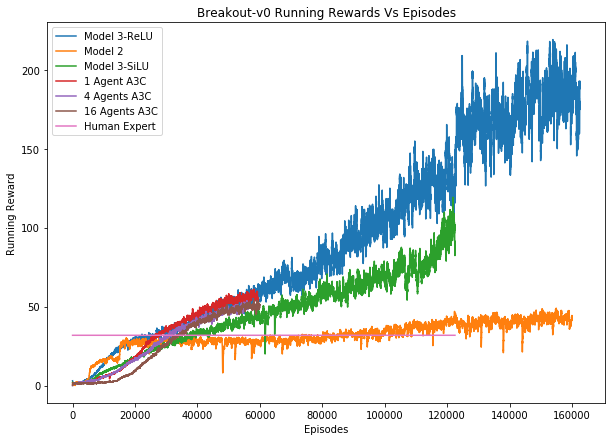

Max. Running Reward (1 Agent A3C): 60.97
Episode achieving max. Running Reward: 58085
Episode achieving Human Performance: 26693


Max. Running Reward (4 Agent A3C): 53.58
Episode achieving max. Running Reward: 55853
Episode achieving Human Performance: 29467


Max. Running Reward (16 Agent A3C): 54.26
Episode achieving max. Running Reward: 58024
Episode achieving Human Performance: 33548


Max. Running Reward (Model 3-ReLU): 219.04
Episode achieving max. Running Reward: 153862
Episode achieving Human Performance: 22201


Episode achieving max. Running Reward: 154934
Max. Running Reward (Model 2): 48.96
Episode achieving Human Performance: 63307


Max. Running Reward (Model 3-SiLU): 119.17
Episode achieving max. Running Reward: 121861
Episode achieving Human Performance: 36721


Human Performance: 31.800


In [3]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Breakout-v0'
plt.figure(figsize=(10, 7))

data_file = './results/Breakout-v0.p'.format(game)
with open(data_file, 'rb') as f:
    data1 = pickle.load(f)

plt.plot(data1, label='Model 3-ReLU')

data_file = './results/Breakout-v0-chris.p'.format(game)
with open(data_file, 'rb') as f:
    data2 = pickle.load(f)

plt.plot(data2[:len(data1)], label='Model 2')

data_file = './results/Breakout-v0_silu_ep=140000.p'.format(game)
with open(data_file, 'rb') as f:
    data3 = pickle.load(f)

plt.plot(data3, label='Model 3-SiLU')

plt.plot( np.arange(0, len(running_rewards1), 1),running_rewards1, label = '1 Agent A3C')
plt.plot( np.arange(0, len(running_rewards4), 1),running_rewards4, label = '4 Agents A3C')
plt.plot( np.arange(0, len(running_rewards16), 1),running_rewards16,label = '16 Agents A3C')

human = [human_scores[game] for _ in range(len(data3))]
plt.plot(human, label='Human Expert')

plt.title("Breakout-v0 Running Rewards Vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Running Reward")
plt.legend()
plt.savefig("./plots/ACL-vs-A3C-Breakout.png")
plt.show()

print('Max. Running Reward (1 Agent A3C): {:.2f}'.format(max(running_rewards1)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards1.index(max(running_rewards1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards1) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (4 Agent A3C): {:.2f}'.format(max(running_rewards4)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards4.index(max(running_rewards4))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards4) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (16 Agent A3C): {:.2f}'.format(max(running_rewards16)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards16.index(max(running_rewards16))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards16) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (Model 3-ReLU): {:.2f}'.format(max(data1)))
print('Episode achieving max. Running Reward: {}'.format(data1.index(max(data1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data1) if v > human_scores[game]][0]))
print('\n')
print('Episode achieving max. Running Reward: {}'.format(data2.index(max(data2))))
print('Max. Running Reward (Model 2): {:.2f}'.format(max(data2)))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data2) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (Model 3-SiLU): {:.2f}'.format(max(data3)))
print('Episode achieving max. Running Reward: {}'.format(data3.index(max(data3))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data3) if v > human_scores[game]][0]))
print('\n')
print('Human Performance: {:.3f}'.format(human_scores[game]))

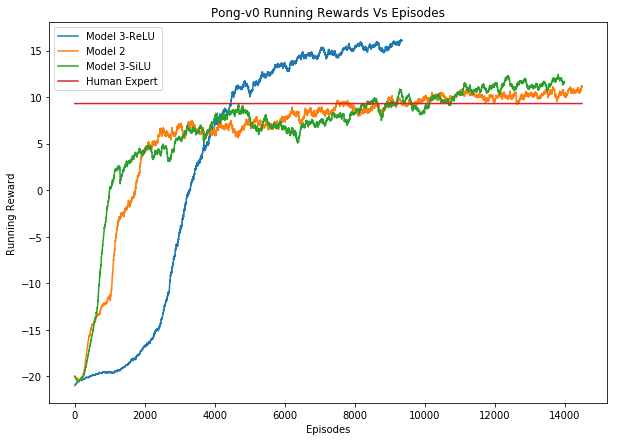

Episode achieving max. Running Reward: 14497
Max. Running Reward (Model 2): 11.21
Episode achieving Human Performance: 7485


Max. Running Reward (Model 3-ReLU): 16.18
Episode achieving max. Running Reward: 9327
Episode achieving Human Performance: 4467


Episode achieving max. Running Reward: 13817
Max. Running Reward (Model 3-SiLU): 12.41
Episode achieving Human Performance: 8248


Human Performance: 9.300


In [6]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'

plt.figure(figsize=(10, 7))

data_file = './results/Pong-v0(AC-lstm-fullepisode-ep=9500).p'.format(game)
with open(data_file, 'rb') as f:
    data1 = pickle.load(f)

plt.plot(data1[:9350], label='Model 3-ReLU')

data_file = './results/Pong-v0-AC-noLSTM.p'.format(game)
with open(data_file, 'rb') as f:
    data2 = pickle.load(f)

plt.plot(data2, label='Model 2')

data_file = './results/Pong-v0_silu_ep=14000.p'.format(game)
with open(data_file, 'rb') as f:
    data3 = pickle.load(f)

plt.plot(data3, label='Model 3-SiLU')

human = [human_scores[game] for _ in range(len(data2))]
plt.plot(human, label='Human Expert')

plt.title("Pong-v0 Running Rewards Vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Running Reward")
plt.legend()
plt.savefig("./plots/Models-Pong.png")
plt.show()

print('Episode achieving max. Running Reward: {}'.format(data2.index(max(data2))))
print('Max. Running Reward (Model 2): {:.2f}'.format(max(data2)))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data2) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (Model 3-ReLU): {:.2f}'.format(max(data1)))
print('Episode achieving max. Running Reward: {}'.format(data1.index(max(data1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data1) if v > human_scores[game]][0]))
print('\n')
print('Episode achieving max. Running Reward: {}'.format(data3.index(max(data3))))
print('Max. Running Reward (Model 3-SiLU): {:.2f}'.format(max(data3)))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data3) if v > human_scores[game]][0]))
print('\n')
print('Human Performance: {:.3f}'.format(human_scores[game]))

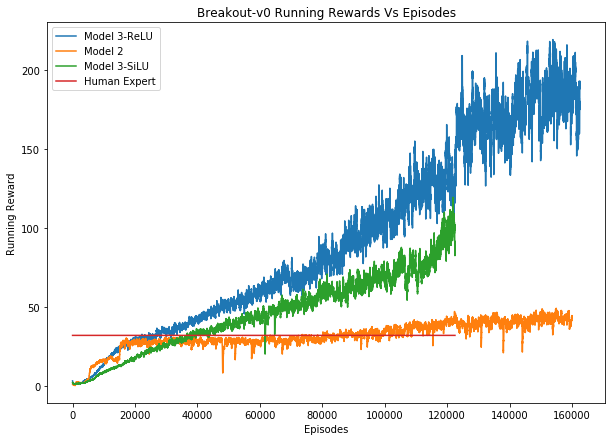

Max. Running Reward (Model 3-ReLU): 219.04
Episode achieving max. Running Reward: 153862
Episode achieving Human Performance: 22201


Max. Running Reward (Model 3-SiLU): 119.17
Episode achieving max. Running Reward: 121861
Episode achieving Human Performance: 36721


Max. Running Reward (Model 2): 48.96
Episode achieving max. Running Reward: 154934
Episode achieving Human Performance: 63307


Human Performance: 31.800


In [4]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Breakout-v0'
plt.figure(figsize=(10, 7))

data_file = './results/Breakout-v0.p'.format(game)
with open(data_file, 'rb') as f:
    data1 = pickle.load(f)

plt.plot(data1, label='Model 3-ReLU')

data_file = './results/Breakout-v0-chris.p'.format(game)
with open(data_file, 'rb') as f:
    data2 = pickle.load(f)

plt.plot(data2[:len(data1)], label='Model 2')

data_file = './results/Breakout-v0_silu_ep=140000.p'.format(game)
with open(data_file, 'rb') as f:
    data3 = pickle.load(f)

plt.plot(data3, label='Model 3-SiLU')

human = [human_scores[game] for _ in range(len(data3))]
plt.plot(human, label='Human Expert')

plt.title("Breakout-v0 Running Rewards Vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Running Reward")
plt.legend()
plt.savefig("./plots/Models-Breakout.png")
plt.show()

print('Max. Running Reward (Model 3-ReLU): {:.2f}'.format(max(data1)))
print('Episode achieving max. Running Reward: {}'.format(data1.index(max(data1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data1) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (Model 3-SiLU): {:.2f}'.format(max(data3)))
print('Episode achieving max. Running Reward: {}'.format(data3.index(max(data3))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data3) if v > human_scores[game]][0]))
print('\n')
print('Max. Running Reward (Model 2): {:.2f}'.format(max(data2)))
print('Episode achieving max. Running Reward: {}'.format(data2.index(max(data2))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data2) if v > human_scores[game]][0]))
print('\n')
print('Human Performance: {:.3f}'.format(human_scores[game]))